# 6. Optimizers

## Introduction to Gradient-descent Optimizers
- based on the original data plus
- http://ruder.io/optimizing-gradient-descent/

## Algorithms
- Optimization Algorithm 1: Batch Gradient Descent
- Optimization Algorithm 2: Stochastic Gradient Descent
- Optimization Algorithm 3: Mini-batch Gradient Descent
- Optimization Algorithm 4: SGD Momentum
- Optimization Algorithm 5: SGD Nesterov
- Optimization Algorithm 6: Adagrad
- Optimization Algorithm 7: RMSProp
- Optimization Algorithm 8: Adam
- Optimization Algorithm 9: Adadelta
- Optimization Algorithm 10: AdaMax
- **Optimization Algorithm 11: RAdam (Rectified Adam)**
- **Optimization Algorithm 12: Lookahead Optimizer: k steps forward, 1 step back**

### Model: 1 Hidden Layer Feedforward Neural Network (ReLU Activation)
<img src="./images/nn1.png" alt="deeplearningwizard" style="width: 900px;"/>

### Steps
- Step 1: Load Dataset
- Step 2: Make Dataset Iterable
- Step 3: Create Model Class
- Step 4: Instantiate Model Class
- Step 5: Instantiate Loss Class
- **Step 6: Instantiate Optimizer Class**
- Step 7: Train Model

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)


'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
         
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.34407174587249756. Accuracy: 91.74
Iteration: 1000. Loss: 0.2057691365480423. Accuracy: 93.15
Iteration: 1500. Loss: 0.26470181345939636. Accuracy: 94.17
Iteration: 2000. Loss: 0.17571502923965454. Accuracy: 94.66
Iteration: 2500. Loss: 0.13576152920722961. Accuracy: 95.49
Iteration: 3000. Loss: 0.11078342795372009. Accuracy: 95.82


### Non-Technical Process 
1. Convert inputs/labels to variables
2. Clear gradient buffers
3. Get output given inputs 
4. Get loss by comparing with labels
5. Get gradients w.r.t. parameters
6. **Update parameters using gradients**
    - `parameters = parameters - learning_rate * parameters_gradients`
7. REPEAT

### Why is it called Gradient Descent? 
- Use gradients (error signals) $\rightarrow$ update parameters to minimize our loss (descent) $\rightarrow$ better predictive accuracy


### Mathematical Interpretation of Gradient Descent
- Model's parameters: $\theta \in ℝ^d$
- Loss function: $J(\theta)$
- Gradient w.r.t. parameters: $ \nabla J(\theta)$
- Learning rate: $\eta$
- Batch Gradient descent: $\theta = \theta - \eta \cdot  \nabla J(\theta)$


## Optimization Algorithm 1: Batch Gradient Descent
- What we've covered so far: batch gradient descent
    - $\theta = \theta - \eta \cdot  \nabla J(\theta)$
- Characteristics
    - Compute the gradient of the loss function w.r.t. parameters for the entire training data, $\nabla J(\theta)$ 
    - Use this to update our parameters at every iteration
- Problems
    - Unable to fit whole datasets in memory 
    - Computationally slow as we attempt to compute a large Jacobian matrix $\rightarrow$ first order derivative, $\nabla J(\theta)$
- Conceptually easy to understand $\rightarrow$ rarely used

## Optimization Algorithm 2: Stochastic Gradient Descent 
- Modification of batch gradient descent
    - $\theta = \theta - \eta \cdot  \nabla J(\theta, x^{i}, y^{i})$
- Characteristics
    - Compute the gradient of the loss function w.r.t. parameters for the **one set of training sample (1 input and 1 label)**, $\nabla J(\theta, x^{i}, y^{i})$
    - Use this to update our parameters at every iteration
- Benefits
    - Able to fit large datasets
    - Computationally faster $\rightarrow$ instead gradients w.r.t to the whole training data, we get the gradients w.r.t. training sample
- Problems
    - Updating very frequently $\rightarrow$ huge variance in parameter updates $\rightarrow$ may overshoot local minima 
        - Can be solved by carefully decaying your learning rate $\rightarrow$ take smaller steps in incorporating gradients to improve the parameters

## Optimization Algorithm 3: Mini-batch Gradient Descent
- Combination of batch gradient descent & stochastic gradient descent
    - $\theta = \theta - \eta \cdot  \nabla J(\theta, x^{i: i+n}, y^{i:i+n})$
- Characteristics
    - Compute the gradient of the loss function w.r.t. parameters for **n sets of training sample (n input and n label)**, $\nabla J(\theta, x^{i: i+n}, y^{i:i+n})$
    - Use this to update our parameters at every iteration
- Benefits
    - Able to fit large datasets
    - Computationally faster $\rightarrow$ instead gradients w.r.t to the whole training data, we get the gradients w.r.t. training sample
    - Lower variance of parameter updates
- This is often called SGD in deep learning frameworks .__.  

In [18]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.34407174587249756. Accuracy: 91.74
Iteration: 1000. Loss: 0.2057691365480423. Accuracy: 93.15
Iteration: 1500. Loss: 0.26470181345939636. Accuracy: 94.17
Iteration: 2000. Loss: 0.17571502923965454. Accuracy: 94.66
Iteration: 2500. Loss: 0.13576152920722961. Accuracy: 95.49
Iteration: 3000. Loss: 0.11078342795372009. Accuracy: 95.82


## SGD의 한계
- Gradient Descent Optimization Algorithms at Long Valley
![](http://i.imgur.com/2dKCQHh.gif?1)

- Gradient Descent Optimization Algorithms at Beale's Function

![](https://www.sfu.ca/~ssurjano/beale.png)
![](https://www.sfu.ca/~ssurjano/beale2.png)
![](http://i.imgur.com/pD0hWu5.gif?1)


- Gradient Descent Optimization Algorithms at Saddle Point
![](http://i.imgur.com/NKsFHJb.gif?1)

- 모든 경우에서 SGD는 다른 알고리즘들에 비해 성능이 월등하게 낮다. 
- 다른 알고리즘들 보다 이동속도가 현저하게 느릴뿐만 아니라, 방향을 제대로 잡지 못하고 이상한 곳에서 수렴하여 이동하지 못하는 모습도 관찰할 수 있다. 
- 즉 단순한 SGD를 이용하여 네트워크를 학습시킬 경우 네트워크가 상대적으로 좋은 결과를 얻지 못할 것이라고 예측할 수 있다

## Optimization Algorithm 4: SGD Momentum
- Modification of SGD
- Momentum 방식은 말 그대로 Gradient Descent를 통해 이동하는 과정에 일종의 ‘관성’을 주는 것이다. 
- 현재 Gradient를 통해 이동하는 방향과는 별개로, 과거에 이동했던 방식을 기억하면서 그 방향으로 일정 정도를 추가적으로 이동하는 방식이다.  
- v_t를 time step t에서의 이동 벡터라고 할 때, 다음과 같은 식으로 이동을 표현할 수 있다.
    - $v_t = \gamma v_{t-1} + \eta \cdot  \nabla J(\theta, x^{i: i+n}, y^{i:i+n})$
    - $\theta = \theta - v_t$
- Characteristics

    - 이 때, γ는 얼마나 momentum을 줄 것인지에 대한 momentum term으로서, 보통 0.9 정도의 값을 사용한다. 
    
    - 식을 살펴보면 과거에 얼마나 이동했는지에 대한 이동 항 v를 기억하고, 새로운 이동항을 구할 경우 과거에 이동했던 정도에 관성항만큼 곱해준 후 Gradient을 이용한 이동 step 항을 더해준다.
    - 이렇게 할 경우 이동항 vt 는 다음과 같은 방식으로 정리할 수 있어, Gradient들의 지수평균을 이용하여 이동한다고도 해석할 수 있다.

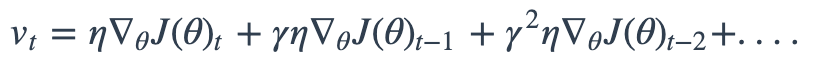


- Momentum 방식은 SGD가 Oscilation 현상을 겪을 때 더욱 빛을 발한다. 다음과 같이 SGD가 Oscilation을 겪고 있는 상황을 보면
![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

- SGD는 중앙의 최적점으로 이동해야하는 상황인데, 한번의 step에서 움직일 수 있는 step size는 한계가 있으므로 이러한 oscilation 현상이 일어날 때는 좌우로 계속 진동하면서 이동에 난항을 겪게 됨

![](http://sebastianruder.com/content/images/2015/12/with_momentum.gif)

- Momentum 방식을 사용할 경우 다음과 같이 자주 이동하는 방향에 관성이 걸리게 되고, 진동을 하더라도 중앙으로 가는 방향에 힘을 얻기 때문에 SGD에 비해 상대적으로 빠르게 이동할 수 있다.



![](http://www.yaldex.com/game-development/FILES/17fig09.gif)
- Momentum 방식을 이용할 경우 위의 그림과 같이 local minima를 빠져나오는 효과가 있을 것이라고도 기대할 수 있다. 
- 기존의 SGD를 이용할 경우 좌측의 local minima에 빠지면 gradient가 0이 되어 이동할 수가 없지만, momentum 방식의 경우 기존에 이동했던 방향에 관성이 있어 이 local minima를 빠져나오고 더 좋은 minima로 이동할 것을 기대할 수 있게 된다. 
- 반면 momentum 방식을 이용할 경우 기존의 변수들 θ 외에도 과거에 이동했던 양을 변수별로 저장해야하므로 변수에 대한 메모리가 기존의 두 배로 필요하게 된다.

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
        
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.16120119392871857. Accuracy: 96.05
Iteration: 1000. Loss: 0.15727555751800537. Accuracy: 96.46
Iteration: 1500. Loss: 0.1303035169839859. Accuracy: 96.84
Iteration: 2000. Loss: 0.022178763523697853. Accuracy: 97.34
Iteration: 2500. Loss: 0.07027596235275269. Accuracy: 97.41
Iteration: 3000. Loss: 0.025198636576533318. Accuracy: 97.42


## Optimization Algorithm 5: SGD Nesterov
- Nesterov Accelerated Gradient(NAG)는 Momentum 방식을 기초로 한 방식이지만, Gradient를 계산하는 방식이 살짝 다르다. 
- 다음 그림을 먼저 살펴보자.

![](http://cs231n.github.io/assets/nn3/nesterov.jpeg)

- Momentum 방식에서는 이동 벡터 vt 를 계산할 때 현재 위치에서의 gradient와 momentum step을 독립적으로 계산하고 합친다. 
- 반면, NAG에서는 momentum step을 먼저 고려하여, momentum step을 먼저 이동했다고 생각한 후 그 자리에서의 gradient를 구해서 gradient step을 이동한다.  (**future approximate parameters**)

- Modification of SGD Momentum 
    - $v_t = \gamma v_{t-1} + \eta \cdot  \nabla J(\theta - \gamma v_{t-1}, x^{i: i+n}, y^{i:i+n})$
    - $\theta = \theta - v_t$
    
- NAG를 이용할 경우 Momentum 방식에 비해 보다 효과적으로 이동할 수 있다. 
- Momentum 방식의 경우 멈춰야 할 시점에서도 관성에 의해 훨씬 멀리 갈수도 있다는 단점이 존재하는 반면, NAG 방식의 경우 일단 모멘텀으로 이동을 반정도 한 후 어떤 방식으로 이동해야할 지를 결정한다. 
- 따라서 Momentum 방식의 빠른 이동에 대한 이점은 누리면서도, 멈춰야 할 적절한 시점에서 제동을 거는 데에 훨씬 용이
- Characteristics
    - Compute the gradient of the lost function w.r.t. **future approximate parameters** for **n sets of training sample (n input and n label)**, $\nabla J(\theta - \gamma v_{t-1}, x^{i: i+n}, y^{i:i+n})$
        - Use this to add to the previous update vector $v_{t-1}$
        - Momentum, usually set to $\gamma = 0.9$
    - Gradients w.r.t. future approximate parameters $\rightarrow$ sense of where we will be $\rightarrow$ anticipate if we are going in the wrong direction in the next step $\rightarrow$ slow down accordingly

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.15292975306510925. Accuracy: 96.26
Iteration: 1000. Loss: 0.11253040283918381. Accuracy: 96.96
Iteration: 1500. Loss: 0.11986587196588516. Accuracy: 96.78
Iteration: 2000. Loss: 0.01619240827858448. Accuracy: 97.25
Iteration: 2500. Loss: 0.0674496665596962. Accuracy: 97.28
Iteration: 3000. Loss: 0.030609717592597008. Accuracy: 97.62


## Other Adaptive Algorithms
- Other adaptive algorithms (like Adam, adapting learning rates)
    - Adagrad
    - Adadelta
    - Adamax
    - RMSProp

## Optimization Algorithm 6: Adagrad
- Adagrad(Adaptive Gradient)는 변수들을 update할 때 각각의 변수마다 step size를 다르게 설정해서 이동하는 방식이다. 
- 이 알고리즘의 기본적인 아이디어는 ‘지금까지 많이 변화하지 않은 변수들은 step size를 크게 하고, 지금까지 많이 변화했던 변수들은 step size를 작게 하자’ 라는 것. 
- 자주 등장하거나 변화를 많이 한 변수들의 경우 optimum에 가까이 있을 확률이 높기 때문에 작은 크기로 이동하면서 세밀한 값을 조정하고, 적게 변화한 변수들은 optimum 값에 도달하기 위해서는 많이 이동해야할 확률이 높기 때문에 먼저 빠르게 loss 값을 줄이는 방향으로 이동하려는 방식이라고 생각할 수 있다. 
- 특히 word2vec이나 GloVe 같이 word representation을 학습시킬 경우 단어의 등장 확률에 따라 variable의 사용 비율이 확연하게 차이나기 때문에 Adagrad와 같은 학습 방식을 이용하면 훨씬 더 좋은 성능을 거둘 수 있다.


- Adagrad의 한 스텝을 수식화하여 나타내면 다음과 같다.
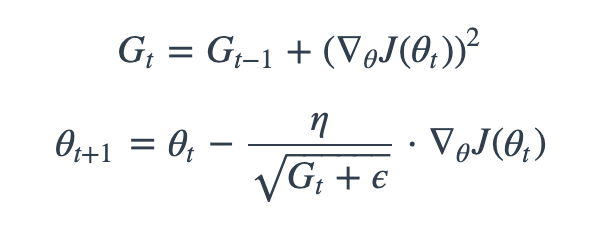

- Neural Network의 parameter가 k개라고 할 때, Gt는 k차원 벡터로서 ‘time step t까지 각 변수가 이동한 gradient의 sum of squares’ 를 저장한다. 
- θ를 업데이트하는 상황에서는 기존 step size η에 Gt의 루트값에 반비례한 크기로 이동을 진행하여, 지금까지 많이 변화한 변수일 수록 적게 이동하고 적게 변화한 변수일 수록 많이 이동하도록 한다. 
- 이 때 ϵ은 10−4 ~ 10−8 정도의 작은 값으로서 0으로 나누는 것을 방지하기 위한 작은 값이다. 
- 여기에서 Gt를 업데이트하는 식에서 제곱은 element-wise 제곱을 의미하며, θ를 업데이트하는 식에서도 ⋅ 은 element-wise한 연산을 의미한다.

- Adagrad를 사용하면 학습을 진행하면서 굳이 step size decay등을 신경써주지 않아도 된다는 장점이 있다. 
- 보통 adagrad에서 step size로는 0.01 정도를 사용한 뒤, 그 이후로는 바꾸지 않는다. 
- 반면, Adagrad에는 학습을 계속 진행하면 step size가 너무 줄어든다는 문제점이 있다. G에는 계속 제곱한 값을 넣어주기 때문에 G의 값들은 계속해서 증가하기 때문에, 학습이 오래 진행될 경우 step size가 너무 작아져서 결국 거의 움직이지 않게 된다. 
- 이를 보완하여 고친 알고리즘이 RMSProp과 AdaDelta이다.

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001

optimizer = torch.optim.Adagrad(model.parameters())

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.2757393717765808. Accuracy: 92.96
Iteration: 1000. Loss: 0.19955307245254517. Accuracy: 93.98
Iteration: 1500. Loss: 0.22258137166500092. Accuracy: 94.42
Iteration: 2000. Loss: 0.18594001233577728. Accuracy: 94.75
Iteration: 2500. Loss: 0.14671525359153748. Accuracy: 95.15
Iteration: 3000. Loss: 0.11712780594825745. Accuracy: 95.42


## Optimization Algorithm 7: RMSProp(Root Mean Square Propagation)
- RMSProp은 딥러닝의 대가 제프리 힌톤이 제안한 방법으로서, Adagrad의 단점을 해결하기 위한 방법이다. 
- Adagrad의 식에서 gradient의 제곱값을 더해나가면서 구한 Gt 부분을 합이 아니라 지수평균으로 바꾸어서 대체한 방법이다. 
- 이렇게 대체를 할 경우 Adagrad처럼 Gt가 무한정 커지지는 않으면서 최근 변화량의 변수간 상대적인 크기 차이는 유지할 수 있다. 
- 식으로 나타내면 다음과 같다.
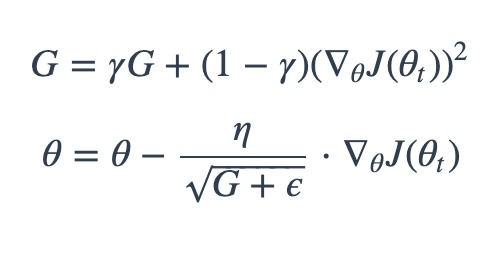

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001

optimizer = torch.optim.RMSprop(model.parameters())

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.21534942090511322. Accuracy: 95.0
Iteration: 1000. Loss: 0.20722238719463348. Accuracy: 95.38
Iteration: 1500. Loss: 0.15398374199867249. Accuracy: 96.7
Iteration: 2000. Loss: 0.1273333579301834. Accuracy: 96.75
Iteration: 2500. Loss: 0.08329834043979645. Accuracy: 96.88
Iteration: 3000. Loss: 0.04977124184370041. Accuracy: 97.09


## Optimization Algorithm 8: Adam
- Adam (Adaptive Moment Estimation)은 RMSProp과 Momentum 방식을 합친 것 같은 알고리즘이다. 
- 이 방식에서는 Momentum 방식과 유사하게 지금까지 계산해온 기울기의 지수평균을 저장하며, RMSProp과 유사하게 기울기의 제곱값의 지수평균을 저장한다.

- Adaptive Learning Rates
    - $m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t$
        - Keeping track of decaying gradient
        - Estimate of the mean of gradients
    - $v_t = \beta_2 v_{t-1} + (1 - \beta_2)g_t^2$
        - Keeping track of decaying squared gradient 
        - Estimate of the variance of gradients
 
- Adam에서는 m과 v가 처음에 0으로 초기화되어 있기 때문에 학습의 초반부에서는 mt,vt가 0에 가깝게 bias 되어있을 것이라고 판단하여 이를 unbiased 하게 만들어주는 작업을 거친다. 
- mt 와 vt의 식을 ∑ 형태로 펼친 후 양변에 expectation을 씌워서 정리해보면, 다음과 같은 보정을 통해 unbiased 된 expectation을 얻을 수 있다. 
- 이 보정된 expectation들을 가지고 gradient가 들어갈 자리에 mt^, Gt가 들어갈 자리에 vt^를 넣어 계산을 진행한다.
        
    - When $m_t, v_t$ initializes as 0, $m_t, v_t \rightarrow 0$ initially when decay rates small, $\beta_1, \beta_2 \rightarrow 1$  
        - Need to correct this with:
        - $ \hat m_t = \frac{m_t}{1- \beta_1}$
        - $ \hat v_t = \frac{v_t}{1- \beta_2}$
    - $\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat v_t} + \epsilon}\hat m_t$
    - Default recommended values
        - $\beta_1 = 0.9$
        - $\beta_2 = 0.999$
        - $\epsilon = 10^{-8}$
- Instead of learning rate $\rightarrow$ equations account for estimates of mean/variance of gradients to determine the next learning rate


In [11]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters())

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.27101942896842957. Accuracy: 93.1
Iteration: 1000. Loss: 0.15515939891338348. Accuracy: 95.02
Iteration: 1500. Loss: 0.17511975765228271. Accuracy: 95.74
Iteration: 2000. Loss: 0.08394313603639603. Accuracy: 96.36
Iteration: 2500. Loss: 0.07022970914840698. Accuracy: 96.63
Iteration: 3000. Loss: 0.04604213684797287. Accuracy: 97.1


## Optimization Algorithm 9: Adadelta
- AdaDelta (Adaptive Delta) 는 RMSProp과 유사하게 AdaGrad의 단점을 보완하기 위해 제안된 방법이다. 
- AdaDelta는 RMSProp과 동일하게 G를 구할 때 합을 구하는 대신 지수평균을 구한다. 
- 다만, 여기에서는 step size를 단순하게 η 로 사용하는 대신 step size의 변화값의 제곱을 가지고 지수평균 값을 사용한다.
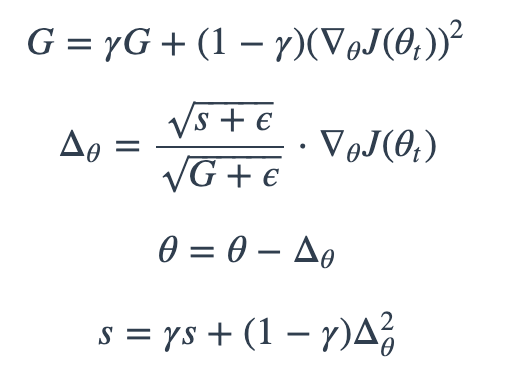

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001

optimizer = torch.optim.Adadelta(model.parameters())

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.2351689338684082. Accuracy: 95.18
Iteration: 1000. Loss: 0.11018890142440796. Accuracy: 96.32
Iteration: 1500. Loss: 0.15829689800739288. Accuracy: 96.96
Iteration: 2000. Loss: 0.057829707860946655. Accuracy: 97.31
Iteration: 2500. Loss: 0.04860945791006088. Accuracy: 97.37
Iteration: 3000. Loss: 0.026529962196946144. Accuracy: 97.53


## Optimization Algorithm 10: Adamax

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001

optimizer = torch.optim.Adamax(model.parameters())

'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.29930347204208374. Accuracy: 92.4
Iteration: 1000. Loss: 0.18749120831489563. Accuracy: 93.83
Iteration: 1500. Loss: 0.21902252733707428. Accuracy: 95.05
Iteration: 2000. Loss: 0.14307661354541779. Accuracy: 95.63
Iteration: 2500. Loss: 0.10742520540952682. Accuracy: 96.1
Iteration: 3000. Loss: 0.08253168314695358. Accuracy: 96.48


### Round up
![](https://image.slidesharecdn.com/random-170910154045/95/-49-638.jpg?cb=1505089848)
- 출처: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

## Optimization Algorithm 11: RAdam (Rectified Adam) 
- newly addeded on Aug, 18th from https://github.com/LiyuanLucasLiu/RAdam#quick-start-guide
- by Hyopil Shin


- Basic Assumption: warmup (an initial period of training with a much lower learning rate) is a requirement for adaptive optimizers to offset excessive variance when the optimizer has only worked with limited training data.
- Here is a visual to show what happens initially to Adam with no warmup — within 10 iterations, the gradient distribution is rapidly perturbed:
![](https://miro.medium.com/max/2438/1*oYWKK26rnR5m9fUko7fSpQ.jpeg)

- Given that warm-up serves as a variance reducer, but the degree of warmup required is unknown and varies dataset to dataset, the authors then moved into determining a mathematical algorithm to serve as a dynamic variance reducer.
![](https://miro.medium.com/max/3378/1*YpHxwaHJYCQtGkDSUIWxbQ.jpeg)

- RAdam provides a dynamic heuristic to provide automated variance reduction and thus removes the need and manual tuning involved with a warmup during training.
- In addition, RAdam is shown to be more robust to learning rate variations (the most important hyperparameter) and provides better training accuracy and generalization on a variety of datasets and within a variety of AI architectures.

In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import radam

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001
#learning_rate = 0.001
lr= 0.01
#weight_decay = 0.1
#lr, betas=betas, eps=eps, weight_decay=weight_decay
#optimizer = torch.optim.RMSprop(model.parameters())
optimizer = radam.AdamW(model.parameters(), lr=lr, eps=1e-8)
#optimizer = radam.AdamW(model.parameters(), lr=1e-2, eps=1e-8)
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.1251850724220276. Accuracy: 96.16
Iteration: 1000. Loss: 0.18088407814502716. Accuracy: 95.74
Iteration: 1500. Loss: 0.1156528890132904. Accuracy: 96.28
Iteration: 2000. Loss: 0.06531528383493423. Accuracy: 97.18
Iteration: 2500. Loss: 0.1124735102057457. Accuracy: 96.84
Iteration: 3000. Loss: 0.10356956720352173. Accuracy: 96.23


## Optimization Algorithm 12: Lookahead Optimizer: k steps forward, 1 step back
- https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d
- newly addeded on Aug, 27th from https://github.com/lonePatient/lookahead_pytorch
- by Hyopil Shin

- Lookahead was introduced in a new paper in part by the famed deep learning researcher Geoffrey Hinton (“LookAhead optimizer: k steps forward, 1 step back” July 2019). 
- Lookahead was inspired by the recent advances in the understanding of neural network loss surfaces and presents a whole new way of stabilizing deep learning training and speed of convergence. 
- Combining RAdam plus LookAhead together (Ranger) produces a dynamic dream team and an even better optimizer than RAdam alone.
- Lookahead : the buddy system for exploring the loss surface = faster, more stable exploration and convergence.
![](https://miro.medium.com/max/4882/1*5vn0EMbJTFP-kLaePIWYgA.jpeg)

- LookAhead is a new development that maintains two sets of weights and then interpolates between them — in effect it allows a faster set of weights to ‘look ahead’ or explore while the slower weights stay behind to provide longer term stability.
- The result is reduced variance during training, and much less sensitivity to sub-optimal hyper-parameters and reduces the need for extensive hyper-parameter tuning. 
- This is done while achieving faster convergence on a variety of deep learning tasks. 

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from optimizer import Lookahead

# Set seed
torch.manual_seed(0)

'''
STEP 1: LOADING DATASET
'''

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

'''
STEP 2: MAKING DATASET ITERABLE
'''

batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

'''
STEP 3: CREATE MODEL CLASS
'''
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28*28
hidden_dim = 100
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()


'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
# learning_rate = 0.001
#learning_rate = 0.001
#lr= 0.001
#weight_decay = 0.1
#lr, betas=betas, eps=eps, weight_decay=weight_decay
#optimizer = torch.optim.RMSprop(model.parameters())
#optimizer = radam.AdamW(model.parameters())
base_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = Lookahead(base_optimizer=base_optimizer,k=5,alpha=0.5)

#optimizer = radam.AdamW(model.parameters(), lr=1e-2, eps=1e-8)
'''
STEP 7: TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
         #######################
        #  USE GPU FOR MODEL  #
        #######################
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                #######################
                #  USE GPU FOR MODEL  #
                #######################
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * float(correct) / float(total)
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.18142494559288025. Accuracy: 96.2
Iteration: 1000. Loss: 0.0920269563794136. Accuracy: 97.03
Iteration: 1500. Loss: 0.13143424689769745. Accuracy: 97.15
Iteration: 2000. Loss: 0.0285932756960392. Accuracy: 97.65
Iteration: 2500. Loss: 0.02815185859799385. Accuracy: 97.45
Iteration: 3000. Loss: 0.05903368815779686. Accuracy: 97.48


## Summary of Optimization Algorithms Performance(based on the original post. It may different from our results here)
- SGD: 95.78%
- **SGD Momentum: 97.69%**
- **SGD Nesterov: 97.58%**
- **Adam: 97.20%**
- Adagrad: 95.51%
- **Adadelta: 97.45%**
- Adamax: 96.58%
- **RMSProp: 97.1%**

## Simple Suggestions
- Momentum/Nesterov
    - Powerful if we control the learning rate schedule
- Adam
    - Lazy to control the learning rate schedule

## Summary
- **Recap of 7 step process**
    - Step 1: Load Dataset
    - Step 2: Make Dataset Iterable
    - Step 3: Create Model Class
    - Step 4: Instantiate Model Class
    - Step 5: Instantiate Loss Class
    - **Step 6: Instantiate Optimizer Class**
    - Step 7: Train Model
- **Step 6**
    - Update parameters using gradients
    - `parameters = parameters - learning_rate * parameters_gradients`
- **Gradient descent**
    - Using gradients (error signals from loss class) to update parameters
- **Mathematical** interpretation: $\theta = \theta - \eta \cdot  \nabla J(\theta)$
- **Optimisation Algorithms**
    - Batch gradient descent
    - Stochastic gradient descent
    - Mini-batch gradient descent (SGD)
    - SGD + Momentum
    - SGD + Nesterov
    - Adam
    - Other adaptive algorithms: adagrad, adamax, adadelta, RMSProp
- **Recommendations**
    - SGD+M
    - SGD+N
    - Adam
    - Try new one! 